# Test 

In [46]:
import pandas as pd

df_test = pd.read_parquet("data/test.parquet")

In [47]:
# Compter le nombre de sessions par utilisateur
sessions_par_user = df_test.groupby('userId')['sessionId'].nunique().reset_index()
sessions_par_user.columns = ['userId', 'nombre_sessions']

# Trier par nombre de sessions décroissant et prendre les 5 premiers
top_5_users = sessions_par_user.sort_values('nombre_sessions', ascending=False).head(5)

print(top_5_users)

       userId  nombre_sessions
739   1261737           134438
307   1116029              112
2848  1979129               99
1899  1663631               97
2009  1703411               96


In [48]:
# 1. Compter le nombre de logs par session
logs_par_session = df_test.groupby('sessionId').size().reset_index(name='nombre_logs')

# 2. Les 5 sessions avec le plus de logs
top_5_sessions = logs_par_session.sort_values('nombre_logs', ascending=False).head(5)
print("Top 5 sessions avec le plus de logs :")
print(top_5_sessions)

# 3. Nombre moyen de logs par session
moyenne_logs = logs_par_session['nombre_logs'].mean()
print(f"\nNombre moyen de logs par session : {moyenne_logs:.2f}")

# Statistiques supplémentaires utiles
print(f"Nombre total de sessions : {len(logs_par_session)}")
print(f"Médiane de logs par session : {logs_par_session['nombre_logs'].median()}")
print(f"Écart-type : {logs_par_session['nombre_logs'].std():.2f}")

Top 5 sessions avec le plus de logs :
        sessionId  nombre_logs
97687      128347         1371
108363     143782         1315
135942     185100         1221
53426       64879         1102
128331     173319         1083

Nombre moyen de logs par session : 30.12
Nombre total de sessions : 145863
Médiane de logs par session : 5.0
Écart-type : 70.93


### Function

In [49]:
data_clean = df_test[df_test['userId'] != '1261737']


In [236]:
"""
Fonction FINALE avec 17 features 100% numériques
Inclut : 10 originales + level (paid/free) + device/browser + ancienneté
"""

import pandas as pd
import numpy as np
from datetime import timedelta
import gc


def parse_user_agent(ua):
    """Parse userAgent pour extraire device type"""
    if pd.isna(ua):
        return 'unknown'
    ua_str = str(ua)
    if 'iPhone' in ua_str:
        return 'mobile'
    elif 'iPad' in ua_str:
        return 'mobile'
    elif 'Android' in ua_str:
        return 'mobile'
    else:
        return 'desktop'


def create_all_features(
    df: pd.DataFrame,
    k: int = 5,
    dataset_start: str = '2018-10-01',
    dataset_end: str = '2018-11-19',
    batch_size: int = 500,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Calcule 17 features numériques pour ML
    
    Colonnes requises dans df:
    - userId, sessionId, time, page, registration, level, userAgent
    
    Features:
    10 originales + 7 nouvelles (level + device + ancienneté)
    
    Returns:
        DataFrame avec (userId, prediction_date, 17 features numériques)
    """
    
    if verbose:
        print("="*80)
        print("CALCUL DES 17 FEATURES (100% NUMÉRIQUES)")
        print("="*80)
        print()
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df['registration'] = pd.to_datetime(df['registration'])
    df = df.sort_values(['userId', 'time']).reset_index(drop=True)
    
    dataset_start = pd.to_datetime(dataset_start)
    dataset_end = pd.to_datetime(dataset_end)
    
    # Flags
    df['is_nextsong'] = (df['page'] == 'NextSong').astype(np.int8)
    df['is_thumbs_up'] = (df['page'] == 'Thumbs Up').astype(np.int8)
    df['is_thumbs_down'] = (df['page'] == 'Thumbs Down').astype(np.int8)
    df['is_error'] = (df['page'] == 'Error').astype(np.int8)
    df['is_help'] = (df['page'] == 'Help').astype(np.int8)
    df['is_settings'] = (df['page'] == 'Settings').astype(np.int8)
    df['is_downgrade'] = (df['page'] == 'Downgrade').astype(np.int8)
    
    # Parse device type
    if verbose:
        print("Parsing userAgent...")
    df['device_type'] = df['userAgent'].apply(parse_user_agent)
    df['is_mobile_action'] = (df['device_type'] == 'mobile').astype(np.int8)
    
    # Dates prédiction
    prediction_dates = []
    current_date = dataset_start + timedelta(days=k)
    while current_date <= dataset_end:
        prediction_dates.append(current_date)
        current_date += timedelta(days=k)
    
    # Groupby
    user_groups = {user_id: group for user_id, group in df.groupby('userId', sort=False)}
    user_ids = list(user_groups.keys())
    
    if verbose:
        print(f"Users: {len(user_ids)}, Dates: {len(prediction_dates)}")
        print()
    
    num_batches = (len(user_ids) + batch_size - 1) // batch_size
    all_features = []
    
    for batch_idx in range(num_batches):
        if verbose:
            print(f"Batch {batch_idx + 1}/{num_batches}...", end=' ')
        
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(user_ids))
        batch_user_ids = user_ids[start_idx:end_idx]
        
        batch_features = []
        
        for user_id in batch_user_ids:
            user_data = user_groups[user_id]
            registration = user_data['registration'].iloc[0]
            
            for pred_date in prediction_dates:
                
                window_14d_start = pred_date - timedelta(days=14)
                window_14d_end = pred_date - timedelta(days=1)
                window_7d_start = pred_date - timedelta(days=7)
                window_15d_start = pred_date - timedelta(days=15)
                
                data_14d = user_data[(user_data['time'] >= window_14d_start) & (user_data['time'] <= window_14d_end)]
                data_7d = user_data[(user_data['time'] >= window_7d_start) & (user_data['time'] <= window_14d_end)]
                data_week2 = user_data[(user_data['time'] >= window_14d_start) & (user_data['time'] < window_7d_start)]
                data_15d = user_data[(user_data['time'] >= window_15d_start) & (user_data['time'] <= window_14d_end)]
                data_lifetime = user_data[user_data['time'] <= window_14d_end]
                
                if len(data_lifetime) == 0:
                    continue
                
                first_activity = data_lifetime['time'].min()
                lifetime_days = (window_14d_end - first_activity).days + 1
                
                # ============================================================
                # 10 FEATURES ORIGINALES
                # ============================================================
                
                # 1. negative_actions_last7d_vs_avg
                thumbs_down_7d = data_7d['is_thumbs_down'].sum()
                negative_7d = thumbs_down_7d + data_7d['is_error'].sum() + data_7d['is_help'].sum() + data_7d['is_settings'].sum()
                negative_lifetime = (data_lifetime['is_thumbs_down'].sum() + 
                                    data_lifetime['is_error'].sum() + 
                                    data_lifetime['is_help'].sum() + 
                                    data_lifetime['is_settings'].sum())
                actions_7d = len(data_7d)
                actions_lifetime = len(data_lifetime)
                negative_7d_norm = negative_7d / max(actions_7d, 1)
                negative_lifetime_norm = negative_lifetime / max(actions_lifetime, 1)
                negative_actions_last7d_vs_avg = negative_7d_norm / max(negative_lifetime_norm, 0.001)
                
                # 2. consistency_score
                date_range = pd.date_range(start=window_14d_start.date(), end=window_14d_end.date(), freq='D')
                daily_sessions = data_14d.groupby('date')['sessionId'].nunique()
                daily_sessions_full = pd.Series(0, index=date_range)
                daily_sessions_full.update(daily_sessions)
                mean_sessions = daily_sessions_full.mean()
                std_sessions = daily_sessions_full.std()
                consistency_score = std_sessions / mean_sessions if mean_sessions > 0 else 0.0
                
                # 3. consecutive_days_inactive
                active_dates = set(data_14d['date'].unique())
                max_consecutive_inactive = 0
                current_streak = 0
                for date in date_range:
                    if date.date() not in active_dates:
                        current_streak += 1
                        max_consecutive_inactive = max(max_consecutive_inactive, current_streak)
                    else:
                        current_streak = 0
                consecutive_days_inactive = max_consecutive_inactive
                
                # 4. session_frequency_change
                sessions_week1 = data_7d['sessionId'].nunique()
                sessions_week2 = data_week2['sessionId'].nunique()
                session_frequency_change = sessions_week1 / max(sessions_week2, 1)
                
                # 5. sessions_last7d_vs_avg
                sessions_7d = data_7d['sessionId'].nunique()
                sessions_lifetime = data_lifetime['sessionId'].nunique()
                sessions_lifetime_avg = sessions_lifetime / max(lifetime_days, 1)
                sessions_7d_avg = sessions_7d / 7
                sessions_last7d_vs_avg = sessions_7d_avg / max(sessions_lifetime_avg, 0.01)
                
                # 6. thumbs_down_last_14days
                thumbs_down_last_14days = data_14d['is_thumbs_down'].sum()
                
                # 7. days_without_thumbs_up
                thumbs_up_data = data_lifetime[data_lifetime['is_thumbs_up'] == 1]
                if len(thumbs_up_data) > 0:
                    last_thumbs_up = thumbs_up_data['time'].max()
                    days_without_thumbs_up = (window_14d_end - last_thumbs_up).days
                else:
                    days_without_thumbs_up = (window_14d_end - registration).days
                
                # 8. has_downgrade_last_15days
                has_downgrade_last_15days = int(data_15d['is_downgrade'].sum() > 0)
                
                # 9. activity_trend_last_14days
                songs_week1 = data_7d['is_nextsong'].sum()
                songs_week2 = data_week2['is_nextsong'].sum()
                activity_trend_last_14days = songs_week1 / max(songs_week2, 1)
                
                # 10. songs_listened_last_14days
                songs_listened_last_14days = data_14d['is_nextsong'].sum()
                
                # ============================================================
                # 7 NOUVELLES FEATURES
                # ============================================================
                
                # 11. is_paid (état actuel = dernier level avant pred_date)
                current_level = data_lifetime.iloc[-1]['level'] if len(data_lifetime) > 0 else 'free'
                is_paid = 1 if current_level == 'paid' else 0
                
                # 12. has_downgraded (a déjà fait paid → free dans l'historique)
                levels = data_lifetime.sort_values('time')['level'].tolist()
                has_downgraded = 0
                for i in range(len(levels) - 1):
                    if levels[i] == 'paid' and levels[i+1] == 'free':
                        has_downgraded = 1
                        break
                
                # 13. mobile_usage_ratio_14d
                mobile_actions_14d = data_14d['is_mobile_action'].sum()
                total_actions_14d = len(data_14d)
                mobile_usage_ratio_14d = mobile_actions_14d / max(total_actions_14d, 1)
                
                # 14. desktop_usage_ratio_14d
                desktop_usage_ratio_14d = 1 - mobile_usage_ratio_14d
                
                # 15. device_switches_14d
                data_14d_sorted = data_14d.sort_values('time')
                device_changes = (data_14d_sorted['device_type'].shift() != data_14d_sorted['device_type']).sum()
                device_switches_14d = int(device_changes)
                
                # 16. days_since_registration
                days_since_registration = (window_14d_end - registration).days
                
                # 17. has_ever_paid (a déjà été paid dans l'historique)
                has_ever_paid = 1 if 'paid' in levels else 0
                
                # ============================================================
                # ASSEMBLER
                # ============================================================
                
                features = {
                    'userId': user_id,
                    'prediction_date': pred_date.date(),
                    'negative_actions_last7d_vs_avg': negative_actions_last7d_vs_avg,
                    'consistency_score': consistency_score,
                    'consecutive_days_inactive': consecutive_days_inactive,
                    'session_frequency_change': session_frequency_change,
                    'sessions_last7d_vs_avg': sessions_last7d_vs_avg,
                    'thumbs_down_last_14days': int(thumbs_down_last_14days),
                    'days_without_thumbs_up': days_without_thumbs_up,
                    'has_downgrade_last_15days': has_downgrade_last_15days,
                    'activity_trend_last_14days': activity_trend_last_14days,
                    'songs_listened_last_14days': int(songs_listened_last_14days),
                    'is_paid': is_paid,
                    'has_downgraded': has_downgraded,
                    'mobile_usage_ratio_14d': mobile_usage_ratio_14d,
                    'desktop_usage_ratio_14d': desktop_usage_ratio_14d,
                    'device_switches_14d': device_switches_14d,
                    'days_since_registration': days_since_registration,
                    'has_ever_paid': has_ever_paid
                }
                
                batch_features.append(features)
        
        if batch_features:
            all_features.append(pd.DataFrame(batch_features))
        
        if verbose:
            print(f"✓ ({len(batch_features)} lignes)")
        
        del batch_features
        gc.collect()
    
    final_df = pd.concat(all_features, ignore_index=True)
    
    if verbose:
        print()
        print("="*80)
        print("✅ 17 FEATURES CRÉÉES (100% NUMÉRIQUES)")
        print("="*80)
        print(f"Shape: {final_df.shape}")
        print()
        print("Aperçu:")
        print(final_df.head())
        print()
        print("Types:")
        print(final_df.dtypes)
    
    return final_df

In [237]:
df_test_features = create_all_features(data_clean)

CALCUL DES 17 FEATURES (100% NUMÉRIQUES)

Parsing userAgent...
Users: 2903, Dates: 9

Batch 1/6... ✓ (4066 lignes)
Batch 2/6... ✓ (4119 lignes)
Batch 3/6... ✓ (4128 lignes)
Batch 4/6... ✓ (4057 lignes)
Batch 5/6... ✓ (4170 lignes)
Batch 6/6... ✓ (3292 lignes)

✅ 17 FEATURES CRÉÉES (100% NUMÉRIQUES)
Shape: (23832, 19)

Aperçu:
    userId prediction_date  negative_actions_last7d_vs_avg  consistency_score  \
0  1000655      2018-10-06                        1.000000           3.741657   
1  1000655      2018-10-11                        1.013158           1.987138   
2  1000655      2018-10-16                        0.000000           1.987138   
3  1000655      2018-10-21                        0.000000           2.541956   
4  1000655      2018-10-26                        0.000000           2.541956   

   consecutive_days_inactive  session_frequency_change  \
0                         11                       1.0   
1                          6                       2.0   
2          

### EDA

In [238]:
df_test_features.describe()

,negative_actions_last7d_vs_avg,consistency_score,consecutive_days_inactive,session_frequency_change,sessions_last7d_vs_avg,thumbs_down_last_14days,days_without_thumbs_up,has_downgrade_last_15days,activity_trend_last_14days,songs_listened_last_14days,is_paid,has_downgraded,mobile_usage_ratio_14d,desktop_usage_ratio_14d,device_switches_14d,days_since_registration,has_ever_paid
count,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000,23832.000000
mean,0.725819,2.001294,6.776939,1.071090,0.663915,3.049052,7.115559,0.455396,24.104884,261.882595,0.513595,0.137840,0.045569,0.954431,0.937689,59.368286,0.595334
std,0.901411,1.060798,3.452783,1.078722,0.509945,4.210003,15.125136,0.498017,69.781753,328.930407,0.499826,0.344739,0.208553,0.208553,0.241725,37.122913,0.490838
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.300887,4.000000,0.333333,0.285714,0.000000,0.000000,0.000000,0.090909,43.000000,0.000000,0.000000,0.000000,1.000000,1.000000,35.000000,0.000000
50%,0.784764,1.987138,6.000000,1.000000,0.642857,1.000000,3.000000,0.000000,0.979592,138.000000,1.000000,0.000000,0.000000,1.000000,1.000000,51.000000,1.000000
75%,1.065557,2.541956,9.000000,1.500000,0.952381,4.000000,7.000000,1.000000,7.000000,356.000000,1.000000,0.000000,0.000000,1.000000,1.000000,75.000000,1.000000
max,31.500000,3.741657,14.000000,15.000000,4.000000,42.000000,253.000000,1.000000,1121.000000,2732.000000,1.000000,1.000000,1.000000,1.000000,1.000000,323.000000,1.000000


### Predict

In [81]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

def XGB_training(df_features):

    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'prediction_date','session_start', 'registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    # Split (NO resampling here!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight: ratio of negative to positive class
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    print(f"Class distribution in train:")
    print(y_train.value_counts())
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost with optimal parameters for churn prediction
    model = xgb.XGBClassifier(
        # Handle imbalanced classes
        scale_pos_weight=scale_pos_weight,  # CRITICAL for imbalanced data
        
        # Model complexity
        n_estimators=100,                   # Number of boosting rounds
        max_depth=6,                        # Tree depth (prevent overfitting)
        learning_rate=0.05,                 # Lower = more robust but slower
        
        # Optimization
        objective='binary:logistic',        # Binary classification,                 
        random_state=42,
        n_jobs=-1
    )

    # Train (simplified - no need to pass eval_metric again)
    print("\nTraining XGBoost model...")
    model.fit(
        X_train, y_train,
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    import pandas as pd
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))
    return model

In [252]:
X_test, y_test, model_XGB = XGB_training(df_consistant)
model_XGB

Class distribution in train:
will_churn_10days
0    92415
1     5422
Name: count, dtype: int64

Calculated scale_pos_weight: 17.04

Training XGBoost model...
balanced accuracy: 0.657951706113036
ROC-AUC: 0.7178

Confusion Matrix:
[[16558  6547]
 [  543   812]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.97      0.72      0.82     23105
       Churn       0.11      0.60      0.19      1355

    accuracy                           0.71     24460
   macro avg       0.54      0.66      0.51     24460
weighted avg       0.92      0.71      0.79     24460


Top 30 Most Important Features:
                       feature  importance
       thumbs_down_last_14days    0.395059
     has_downgrade_last_15days    0.097737
                       is_paid    0.082145
     consecutive_days_inactive    0.069191
             consistency_score    0.061842
                 has_ever_paid    0.050154
        days_without_thumbs_up    0.045705
      sessi

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)

In [253]:
df_test_features.dtypes

userId                             object
prediction_date                    object
negative_actions_last7d_vs_avg    float64
consistency_score                 float64
consecutive_days_inactive           int64
session_frequency_change          float64
sessions_last7d_vs_avg            float64
thumbs_down_last_14days             int64
days_without_thumbs_up              int64
has_downgrade_last_15days           int64
activity_trend_last_14days        float64
songs_listened_last_14days          int64
is_paid                             int64
has_downgraded                      int64
mobile_usage_ratio_14d            float64
desktop_usage_ratio_14d           float64
device_switches_14d                 int64
days_since_registration             int64
has_ever_paid                       int64
dtype: object

In [254]:
def predict_churn(model, df_test_features, best_threshold=0.5):
    """
    Predict churn on test data using trained model with custom threshold.
    
    Parameters:
    -----------
    model : trained classifier (RandomForest, XGBoost, etc.)
        Model from training function
    df_test_features : pd.DataFrame
        Output from create_features_test()
    best_threshold : float, default=0.5
        Optimal threshold for classification (from threshold optimization)
    
    Returns:
    --------
    pd.DataFrame with predictions and probabilities
    """
    # Prepare features (same as training)
    feature_cols = [col for col in df_test_features.columns 
                    if col not in ['userId', 'prediction_date', 'prediction_date', 'session_start', 'registration']]
    X_test = df_test_features[feature_cols].fillna(0)
    
    print(f"Predicting on {len(X_test):,} sessions...")
    print(f"Using threshold: {best_threshold:.3f}")
    
    # Get probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Apply custom threshold
    y_pred = (y_pred_proba >= best_threshold).astype(int)
    
    # Create results dataframe
    results = df_test_features[['userId']].copy()
    results['churn_probability'] = y_pred_proba
    results['predicted_churn'] = y_pred
    
    # Statistics
    print(f"\n{'='*50}")
    print(f"PREDICTIONS (threshold = {best_threshold:.3f})")
    print(f"{'='*50}")
    print(f"  Will churn (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")
    print(f"  No churn (0):   {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")
    print(f"\nProbability Statistics:")
    print(f"  Average: {y_pred_proba.mean():.3f}")
    print(f"  Median:  {np.median(y_pred_proba):.3f}")
    print(f"  Min:     {y_pred_proba.min():.3f}")
    print(f"  Max:     {y_pred_proba.max():.3f}")
    print(f"\nRisk Segments:")
    print(f"{'='*50}\n")
    
    return results

In [255]:
# Meilleur threshold basé sur les résultats du test: 0.55
best_threshold = 0.55

In [256]:
df_test_features.columns

Index(['userId', 'prediction_date', 'negative_actions_last7d_vs_avg',
       'consistency_score', 'consecutive_days_inactive',
       'session_frequency_change', 'sessions_last7d_vs_avg',
       'thumbs_down_last_14days', 'days_without_thumbs_up',
       'has_downgrade_last_15days', 'activity_trend_last_14days',
       'songs_listened_last_14days', 'is_paid', 'has_downgraded',
       'mobile_usage_ratio_14d', 'desktop_usage_ratio_14d',
       'device_switches_14d', 'days_since_registration', 'has_ever_paid'],
      dtype='object')

In [257]:
# 3. Predict
submission = predict_churn(model_XGB, df_test_features, best_threshold=0.45)

Predicting on 23,832 sessions...
Using threshold: 0.450

PREDICTIONS (threshold = 0.450)
  Will churn (1): 12,491 (52.4%)
  No churn (0):   11,341 (47.6%)

Probability Statistics:
  Average: 0.479
  Median:  0.459
  Min:     0.133
  Max:     0.876

Risk Segments:



In [258]:
# Créer une ligne pour user 1261737
new_row = pd.DataFrame({
    'userId': ['1261737'],
    'predicted_churn': [0]
})

# Ajouter à ton submission
submission_complete = pd.concat([submission, new_row], ignore_index=True)

print(f"Submission before: {len(submission)} rows")
print(f"Submission after: {len(submission_complete)} rows")

# Vérifier
print(f"\nUser 1261737 in submission: {'1261737' in submission_complete['userId'].values}")

Submission before: 23832 rows
Submission after: 23833 rows

User 1261737 in submission: True


In [259]:
# Renommer les colonnes pour Kaggle
submission_final = submission_complete.rename(columns={
    'userId': 'id',
    'predicted_churn': 'target'
})

# Vérifier
print("Submission structure:")
print(submission_final.head())
print(f"\nColumns: {submission_final.columns.tolist()}")
print(f"Shape: {submission_final.shape}")

# Vérifier pas de null
print(f"\nNull values: {submission_final.isnull().sum()}")

print("\n✓ Submission ready with columns: id, target")

Submission structure:
        id  churn_probability  target
0  1000655           0.443149       0
1  1000655           0.469241       1
2  1000655           0.388707       0
3  1000655           0.333975       0
4  1000655           0.333975       0

Columns: ['id', 'churn_probability', 'target']
Shape: (23833, 3)

Null values: id                   0
churn_probability    1
target               0
dtype: int64

✓ Submission ready with columns: id, target


In [260]:
# Grouper par userId : 1 si au moins un 1, sinon 0
submission_final = submission_final.groupby('id').agg({
    'target': 'max'  # max = 1 si au moins un 1, sinon 0
}).reset_index()

print(f"After deduplication: {len(submission_final)} unique users")
print(f"\nTarget distribution:")
print(submission_final['target'].value_counts())

# Vérifier plus de duplicates
print(f"\nDuplicates: {submission_final['id'].duplicated().sum()}")


After deduplication: 2889 unique users

Target distribution:
target
1    2364
0     525
Name: count, dtype: int64

Duplicates: 0


In [261]:
# 1. Identifier les userId manquants
expected_users = df_test['userId'].unique()
submitted_users = submission_final['id'].unique()

print(f"Expected users: {len(expected_users)}")
print(f"Submitted users: {len(submitted_users)}")

# Trouver les manquants
missing_users = set(expected_users) - set(submitted_users)
print(f"\nMissing users: {len(missing_users)}")
print(f"Missing user IDs: {list(missing_users)[:10]}")  # Afficher les 10 premiers

# 2. Créer des lignes pour les utilisateurs manquants (avec target=0)
missing_rows = pd.DataFrame({
    'id': list(missing_users),
    'target': 0
})

# 3. Ajouter à la submission
submission_complete = pd.concat([submission_final, missing_rows], ignore_index=True)

print(f"\nBefore adding missing: {len(submission_final)} rows")
print(f"After adding missing: {len(submission_complete)} rows")

# 4. Vérifier qu'on a bien 2904
assert len(submission_complete) == 2904, f"Expected 2904, got {len(submission_complete)}"

# 5. Trier par id (optionnel mais propre)
submission_complete = submission_complete.sort_values('id').reset_index(drop=True)

# 6. Sauvegarder
submission_complete.to_csv('submission.csv', index=False)
print("\n✓ Complete submission with all 2904 users saved!")

Expected users: 2904
Submitted users: 2889

Missing users: 15
Missing user IDs: ['1379547', '1940610', '1912256', '1311784', '1622301', '1222773', '1663319', '1394356', '1961010', '1383001']

Before adding missing: 2889 rows
After adding missing: 2904 rows

✓ Complete submission with all 2904 users saved!


# Train

The competition is to be performed in groups of two. You'll have a report of 4 pages to submit by december 14th, presenting the methods you tested and used. For the defense you'll get 8 minutes of presentations + 7 minutes of questions, including on question on the labs, that may involve writing a code snippet.


Churn prediction 25/26
**Predict churn prediction from streaming service logs**

The goal of the competition is to predict whether or not some users (whose user ids are in the test file) will **churn in the window of 10 days that follows the given observations (ie after "2018-11-20")**. We consider that a user churns when they visit the page **'Cancellation Confirmation'** (edited) 


In [119]:
import pandas as pd

df_train_test = pd.read_parquet("data/test.parquet")
df_train = pd.read_parquet("data/train.parquet")

In [197]:
df_train

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration,will_churn_10days
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21,0
1,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21,0
2,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21,0
3,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21,0
4,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17317562,200,F,Kamaria,free,Alexander,1668706,1541807351000,Logged In,Roll Advert,1430,"Fargo, ND-MN",44,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",GET,NaN,None,None,2018-11-09 23:49:11,2018-08-27 08:53:07,0
17317563,200,F,Kamaria,free,Alexander,1668706,1541807414000,Logged In,NextSong,1430,"Fargo, ND-MN",45,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,251.71546,The Truth Of A Liar,August Burns Red,2018-11-09 23:50:14,2018-08-27 08:53:07,0
17317564,200,F,Kamaria,free,Alexander,1668706,1541807491000,Logged In,About,1430,"Fargo, ND-MN",46,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",GET,NaN,None,None,2018-11-09 23:51:31,2018-08-27 08:53:07,0
17317565,200,F,Kamaria,free,Alexander,1668706,1541807665000,Logged In,NextSong,1430,"Fargo, ND-MN",47,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PUT,258.55955,Cosmic Love,Florence + The Machine,2018-11-09 23:54:25,2018-08-27 08:53:07,0


### Creation of target feature

In [139]:
# Supprimer users qui churnent dans les 7 premiers jours
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churners['days_since_start'] = (churners['time'] - df_train['time'].min()).dt.days
early_churners = churners[churners['days_since_start'] <= 7]['userId'].unique()

df_train = df_train[~df_train['userId'].isin(early_churners)]

print(f"Avant: {df_train['userId'].nunique()}, Après: {df_train['userId'].nunique()}, Supprimé: {len(early_churners)}")

Avant: 18304, Après: 18304, Supprimé: 836


In [140]:
# Creating cancellation in following ten days column

import numpy as np

cancellation_events = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
cancellation_events = cancellation_events[['userId', 'time']].rename(columns={'time': 'churn_time'})

df_train = df_train.merge(cancellation_events, on='userId', how='left')

df_train['days_until_churn'] = (df_train['churn_time'] - df_train['time']).dt.total_seconds() / (24 * 3600)

df_train['will_churn_10days'] = ((df_train['days_until_churn'] >= 0) & 
                                   (df_train['days_until_churn'] <= 10)).astype(int)

df_train = df_train.drop(['churn_time', 'days_until_churn'], axis=1)

In [141]:
df_train.describe() #max time is 2018-11-20 so we are going to keep only the rows that are at least 10 days old OR that have churn True

df_train = df_train[(df_train["time"] < "2018-11-10" )| (df_train["will_churn_10days"] == 1)]

## Preliminary EDA

In [142]:
import pandas as pd
import numpy as np

# Identifier les churners et leur date de churn
churners = df_train[df_train['page'] == 'Cancellation Confirmation'].copy()
churn_dates = churners.groupby('userId')['time'].min().reset_index()
churn_dates.columns = ['userId', 'churn_date']

print(f"Nombre d'utilisateurs qui ont churné : {len(churn_dates)}")
print(f"Taux de churn global : {len(churn_dates) / df_train['userId'].nunique() * 100:.2f}%")
churn_dates['churn_date'] = churn_dates['churn_date'].dt.date
churn_dates

Nombre d'utilisateurs qui ont churné : 3435
Taux de churn global : 19.03%


,userId,churn_date
0,1000025,2018-10-18
1,1000083,2018-10-12
2,1000280,2018-11-13
3,1000353,2018-10-22
4,1000503,2018-10-13
...,...,...
3430,1998845,2018-10-24
3431,1998879,2018-10-21
3432,1999022,2018-11-04
3433,1999847,2018-10-18


## Feature preprocessing

In [ ]:
print(f"Shape avant nettoyage: {df_train.shape}")
print(f"Mémoire avant: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Garder uniquement les colonnes nécessaires
colonnes_necessaires = ['userId', 'sessionId', 'level', 'userAgent', 'time', 'page', 'length', 'registration']
df_train = df_train[colonnes_necessaires].copy()

print(f"Shape après nettoyage: {df_train.shape}")
print(f"Mémoire après: {df_train.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Supprimer le leakage
df_train = df_train[~df_train['page'].isin(['Cancel', 'Cancellation Confirmation'])]

Shape avant nettoyage: (14657548, 35)
Mémoire avant: 16.19 GB
Shape après nettoyage: (14657548, 6)
Mémoire après: 2.24 GB


In [ ]:
df_train

,sessionId,time,length,registration
count,1.464901e+07,14649006,1.195098e+07,14649006
mean,7.295096e+04,2018-10-20 22:48:44.268223,2.487060e+02,2018-08-25 02:18:16.194413
min,1.000000e+00,2018-10-01 00:00:01,5.220000e-01,2017-10-14 22:05:25
25%,2.128700e+04,2018-10-10 17:35:37,1.998624e+02,2018-08-10 22:00:31
50%,6.792400e+04,2018-10-20 08:40:48.500000,2.340828e+02,2018-09-05 15:53:20
75%,1.190990e+05,2018-10-30 23:09:25,2.768714e+02,2018-09-20 15:27:40
max,2.047110e+05,2018-11-19 23:54:05,3.024666e+03,2018-11-14 23:31:27
std,5.299935e+04,NaN,9.725864e+01,NaN


## Sous le capot

### Current function

In [ ]:
"""
Fonction FINALE avec features de frustration + nettoyage
16 features (enlevé desktop_usage_ratio_14d et device_switches_14d)
Ajouté : help_visits_14d, error_rate_14d, settings_visits_14d, frustration_score
"""

import pandas as pd
import numpy as np
from datetime import timedelta
import gc


def create_final_features(
    df: pd.DataFrame,
    k: int = 5,
    dataset_start: str = '2018-10-01',
    dataset_end: str = '2018-11-19',
    batch_size: int = 500,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Calcule 19 features finales (100% numériques)
    
    10 originales + 4 frustration + 5 autres - 2 inutiles = 19 features
    
    Colonnes requises: userId, sessionId, time, page, registration, level, userAgent
    
    Returns:
        DataFrame avec (userId, prediction_date, 19 features)
    """
    
    if verbose:
        print("="*80)
        print("CALCUL DES 19 FEATURES FINALES (+ FRUSTRATION)")
        print("="*80)
        print()
    
    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df['registration'] = pd.to_datetime(df['registration'])
    df = df.sort_values(['userId', 'time']).reset_index(drop=True)
    
    dataset_start = pd.to_datetime(dataset_start)
    dataset_end = pd.to_datetime(dataset_end)
    
    # Flags
    df['is_nextsong'] = (df['page'] == 'NextSong').astype(np.int8)
    df['is_thumbs_up'] = (df['page'] == 'Thumbs Up').astype(np.int8)
    df['is_thumbs_down'] = (df['page'] == 'Thumbs Down').astype(np.int8)
    df['is_error'] = (df['page'] == 'Error').astype(np.int8)
    df['is_help'] = (df['page'] == 'Help').astype(np.int8)
    df['is_settings'] = (df['page'] == 'Settings').astype(np.int8)
    df['is_downgrade'] = (df['page'] == 'Downgrade').astype(np.int8)
    
    # Parse device (garder seulement mobile_ratio)
    if verbose:
        print("Parsing userAgent...")
    
    def parse_ua(ua):
        if pd.isna(ua):
            return 'unknown'
        ua_str = str(ua)
        if 'iPhone' in ua_str or 'iPad' in ua_str or 'Android' in ua_str:
            return 'mobile'
        return 'desktop'
    
    df['device_type'] = df['userAgent'].apply(parse_ua)
    df['is_mobile_action'] = (df['device_type'] == 'mobile').astype(np.int8)
    
    # Dates prédiction
    prediction_dates = []
    current_date = dataset_start + timedelta(days=k)
    while current_date <= dataset_end:
        prediction_dates.append(current_date)
        current_date += timedelta(days=k)
    
    # Groupby
    user_groups = {user_id: group for user_id, group in df.groupby('userId', sort=False)}
    user_ids = list(user_groups.keys())
    
    if verbose:
        print(f"Users: {len(user_ids)}, Dates: {len(prediction_dates)}")
        print()
    
    num_batches = (len(user_ids) + batch_size - 1) // batch_size
    all_features = []
    
    for batch_idx in range(num_batches):
        if verbose:
            print(f"Batch {batch_idx + 1}/{num_batches}...", end=' ')
        
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(user_ids))
        batch_user_ids = user_ids[start_idx:end_idx]
        
        batch_features = []
        
        for user_id in batch_user_ids:
            user_data = user_groups[user_id]
            registration = user_data['registration'].iloc[0]
            
            for pred_date in prediction_dates:
                
                window_14d_start = pred_date - timedelta(days=14)
                window_14d_end = pred_date - timedelta(days=1)
                window_7d_start = pred_date - timedelta(days=7)
                window_15d_start = pred_date - timedelta(days=15)
                
                data_14d = user_data[(user_data['time'] >= window_14d_start) & (user_data['time'] <= window_14d_end)]
                data_7d = user_data[(user_data['time'] >= window_7d_start) & (user_data['time'] <= window_14d_end)]
                data_week2 = user_data[(user_data['time'] >= window_14d_start) & (user_data['time'] < window_7d_start)]
                data_15d = user_data[(user_data['time'] >= window_15d_start) & (user_data['time'] <= window_14d_end)]
                data_lifetime = user_data[user_data['time'] <= window_14d_end]
                
                if len(data_lifetime) == 0:
                    continue
                
                first_activity = data_lifetime['time'].min()
                lifetime_days = (window_14d_end - first_activity).days + 1
                
                # ============================================================
                # 10 FEATURES ORIGINALES
                # ============================================================
                
                # 1. negative_actions_last7d_vs_avg
                thumbs_down_7d = data_7d['is_thumbs_down'].sum()
                negative_7d = thumbs_down_7d + data_7d['is_error'].sum() + data_7d['is_help'].sum() + data_7d['is_settings'].sum()
                negative_lifetime = (data_lifetime['is_thumbs_down'].sum() + 
                                    data_lifetime['is_error'].sum() + 
                                    data_lifetime['is_help'].sum() + 
                                    data_lifetime['is_settings'].sum())
                actions_7d = len(data_7d)
                actions_lifetime = len(data_lifetime)
                negative_7d_norm = negative_7d / max(actions_7d, 1)
                negative_lifetime_norm = negative_lifetime / max(actions_lifetime, 1)
                negative_actions_last7d_vs_avg = negative_7d_norm / max(negative_lifetime_norm, 0.001)
                
                # 2. consistency_score
                date_range = pd.date_range(start=window_14d_start.date(), end=window_14d_end.date(), freq='D')
                daily_sessions = data_14d.groupby('date')['sessionId'].nunique()
                daily_sessions_full = pd.Series(0, index=date_range)
                daily_sessions_full.update(daily_sessions)
                mean_sessions = daily_sessions_full.mean()
                std_sessions = daily_sessions_full.std()
                consistency_score = std_sessions / mean_sessions if mean_sessions > 0 else 0.0
                
                # 3. consecutive_days_inactive
                active_dates = set(data_14d['date'].unique())
                max_consecutive_inactive = 0
                current_streak = 0
                for date in date_range:
                    if date.date() not in active_dates:
                        current_streak += 1
                        max_consecutive_inactive = max(max_consecutive_inactive, current_streak)
                    else:
                        current_streak = 0
                consecutive_days_inactive = max_consecutive_inactive
                
                # 4. session_frequency_change
                sessions_week1 = data_7d['sessionId'].nunique()
                sessions_week2 = data_week2['sessionId'].nunique()
                session_frequency_change = sessions_week1 / max(sessions_week2, 1)
                
                # 5. sessions_last7d_vs_avg
                sessions_7d = data_7d['sessionId'].nunique()
                sessions_lifetime = data_lifetime['sessionId'].nunique()
                sessions_lifetime_avg = sessions_lifetime / max(lifetime_days, 1)
                sessions_7d_avg = sessions_7d / 7
                sessions_last7d_vs_avg = sessions_7d_avg / max(sessions_lifetime_avg, 0.01)
                
                # 6. thumbs_down_last_14days
                thumbs_down_last_14days = data_14d['is_thumbs_down'].sum()
                
                # 7. days_without_thumbs_up
                thumbs_up_data = data_lifetime[data_lifetime['is_thumbs_up'] == 1]
                if len(thumbs_up_data) > 0:
                    last_thumbs_up = thumbs_up_data['time'].max()
                    days_without_thumbs_up = (window_14d_end - last_thumbs_up).days
                else:
                    days_without_thumbs_up = (window_14d_end - registration).days
                
                # 8. has_downgrade_last_15days
                has_downgrade_last_15days = int(data_15d['is_downgrade'].sum() > 0)
                
                # 9. activity_trend_last_14days
                songs_week1 = data_7d['is_nextsong'].sum()
                songs_week2 = data_week2['is_nextsong'].sum()
                activity_trend_last_14days = songs_week1 / max(songs_week2, 1)
                
                # 10. songs_listened_last_14days
                songs_listened_last_14days = data_14d['is_nextsong'].sum()
                
                # ============================================================
                # 4 NOUVELLES FEATURES DE FRUSTRATION
                # ============================================================
                
                # 11. help_visits_14d
                help_visits_14d = data_14d['is_help'].sum()
                
                # 12. error_rate_14d
                errors_14d = data_14d['is_error'].sum()
                total_actions_14d = len(data_14d)
                error_rate_14d = errors_14d / max(total_actions_14d, 1)
                
                # 13. settings_visits_14d
                settings_visits_14d = data_14d['is_settings'].sum()
                
                # 14. frustration_score
                frustration_score = (
                    thumbs_down_last_14days * 2.0 +
                    help_visits_14d * 1.5 +
                    settings_visits_14d * 1.5 +
                    has_downgrade_last_15days * 3.0
                )
                
                # ============================================================
                # 5 AUTRES FEATURES (level + mobile + ancienneté)
                # ============================================================
                
                # 15. is_paid
                current_level = data_lifetime.iloc[-1]['level'] if len(data_lifetime) > 0 else 'free'
                is_paid = 1 if current_level == 'paid' else 0
                
                # 16. has_downgraded
                levels = data_lifetime.sort_values('time')['level'].tolist()
                has_downgraded = 0
                for i in range(len(levels) - 1):
                    if levels[i] == 'paid' and levels[i+1] == 'free':
                        has_downgraded = 1
                        break
                
                # 17. mobile_usage_ratio_14d
                mobile_actions_14d = data_14d['is_mobile_action'].sum()
                mobile_usage_ratio_14d = mobile_actions_14d / max(total_actions_14d, 1)
                
                # 18. days_since_registration
                days_since_registration = (window_14d_end - registration).days
                
                # 19. has_ever_paid
                has_ever_paid = 1 if 'paid' in levels else 0
                
                # ============================================================
                # ASSEMBLER (19 features)
                # ============================================================
                
                features = {
                    'userId': user_id,
                    'prediction_date': pred_date.date(),
                    # 10 originales
                    'negative_actions_last7d_vs_avg': negative_actions_last7d_vs_avg,
                    'consistency_score': consistency_score,
                    'consecutive_days_inactive': consecutive_days_inactive,
                    'session_frequency_change': session_frequency_change,
                    'sessions_last7d_vs_avg': sessions_last7d_vs_avg,
                    'thumbs_down_last_14days': int(thumbs_down_last_14days),
                    'days_without_thumbs_up': days_without_thumbs_up,
                    'has_downgrade_last_15days': has_downgrade_last_15days,
                    'activity_trend_last_14days': activity_trend_last_14days,
                    'songs_listened_last_14days': int(songs_listened_last_14days),
                    # 4 frustration
                    'help_visits_14d': int(help_visits_14d),
                    'error_rate_14d': error_rate_14d,
                    'settings_visits_14d': int(settings_visits_14d),
                    'frustration_score': frustration_score,
                    # 5 autres
                    'is_paid': is_paid,
                    'has_downgraded': has_downgraded,
                    'mobile_usage_ratio_14d': mobile_usage_ratio_14d,
                    'days_since_registration': days_since_registration,
                    'has_ever_paid': has_ever_paid
                }
                
                batch_features.append(features)
        
        if batch_features:
            all_features.append(pd.DataFrame(batch_features))
        
        if verbose:
            print(f"✓ ({len(batch_features)} lignes)")
        
        del batch_features
        gc.collect()
    
    final_df = pd.concat(all_features, ignore_index=True)
    
    if verbose:
        print()
        print("="*80)
        print("✅ 19 FEATURES CRÉÉES")
        print("="*80)
        print(f"Shape: {final_df.shape}")
        print()
        print("Features de frustration ajoutées:")
        print("  - help_visits_14d")
        print("  - error_rate_14d")
        print("  - settings_visits_14d")
        print("  - frustration_score (combinaison)")
        print()
        print("Features supprimées:")
        print("  - desktop_usage_ratio_14d (redondant)")
        print("  - device_switches_14d (0% importance)")
        print()
        print(final_df.head())
    
    return final_df

FileNotFoundError: [Errno 2] No such file or directory: 'df_train.csv'

In [263]:
best_features = create_final_features(df_train)

CALCUL DES 19 FEATURES FINALES (+ FRUSTRATION)

Parsing userAgent...
Users: 18048, Dates: 9

Batch 1/37... ✓ (4047 lignes)
Batch 2/37... ✓ (4006 lignes)
Batch 3/37... ✓ (4027 lignes)
Batch 4/37... ✓ (4031 lignes)
Batch 5/37... ✓ (4086 lignes)
Batch 6/37... ✓ (3973 lignes)
Batch 7/37... ✓ (4018 lignes)
Batch 8/37... ✓ (4066 lignes)
Batch 9/37... ✓ (3969 lignes)
Batch 10/37... ✓ (4027 lignes)
Batch 11/37... ✓ (3980 lignes)
Batch 12/37... ✓ (4060 lignes)
Batch 13/37... ✓ (4020 lignes)
Batch 14/37... ✓ (4038 lignes)
Batch 15/37... ✓ (3994 lignes)
Batch 16/37... ✓ (3984 lignes)
Batch 17/37... ✓ (3987 lignes)
Batch 18/37... ✓ (4036 lignes)
Batch 19/37... ✓ (4012 lignes)
Batch 20/37... ✓ (4021 lignes)
Batch 21/37... ✓ (3985 lignes)
Batch 22/37... ✓ (4006 lignes)
Batch 23/37... ✓ (3994 lignes)
Batch 24/37... ✓ (3977 lignes)
Batch 25/37... ✓ (3997 lignes)
Batch 26/37... ✓ (4029 lignes)
Batch 27/37... ✓ (4030 lignes)
Batch 28/37... ✓ (4030 lignes)
Batch 29/37... ✓ (4023 lignes)
Batch 30/37... ✓ 

In [264]:
best_features

,userId,prediction_date,negative_actions_last7d_vs_avg,consistency_score,consecutive_days_inactive,session_frequency_change,sessions_last7d_vs_avg,thumbs_down_last_14days,days_without_thumbs_up,has_downgrade_last_15days,...,songs_listened_last_14days,help_visits_14d,error_rate_14d,settings_visits_14d,frustration_score,is_paid,has_downgraded,mobile_usage_ratio_14d,days_since_registration,has_ever_paid
0,1000025,2018-10-06,1.000000,2.139374,10,3.000000,0.428571,8,0,1,...,613,4,0.000000,1,26.5,1,0,0.0,86,1
1,1000025,2018-10-11,0.937928,1.158805,5,3.000000,0.857143,10,0,1,...,767,4,0.000000,2,32.0,1,0,0.0,91,1
2,1000025,2018-10-16,0.558397,0.784465,3,0.833333,0.844156,10,3,1,...,1030,5,0.000000,4,36.5,1,0,0.0,96,1
3,1000025,2018-10-21,0.985478,0.865449,2,1.000000,0.907563,5,1,1,...,1024,4,0.000808,7,29.5,1,0,0.0,101,1
4,1000025,2018-10-26,0.000000,1.496663,7,0.000000,0.000000,3,6,1,...,638,3,0.001328,4,19.5,1,0,0.0,106,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144917,1999905,2018-10-26,0.622857,1.640825,4,1.000000,0.816327,2,1,0,...,78,0,0.000000,0,4.0,0,0,0.0,92,0
144918,1999905,2018-10-31,0.000000,1.773306,4,0.666667,0.793651,1,3,0,...,98,0,0.000000,0,2.0,0,0,0.0,97,0
144919,1999905,2018-11-05,0.910920,2.139374,4,0.333333,0.428571,1,3,0,...,124,0,0.000000,1,3.5,0,0,0.0,102,0
144920,1999905,2018-11-10,0.000000,3.741657,9,0.000000,0.000000,0,8,0,...,41,0,0.000000,1,1.5,0,0,0.0,107,0


In [265]:
churn_time = churners[['userId', 'time']].copy()

In [266]:
# Nettoyer
features = best_features.copy()
features = features.merge(churners[['userId', 'time']], on='userId', how='left')
features_clean = features[(features['time'].isna()) | (features['prediction_date'] < features['time'])].drop('time', axis=1)

print(f"Avant: {len(features)}, Après: {len(features_clean)}, Supprimé: {len(features) - len(features_clean)}")

Avant: 144922, Après: 131113, Supprimé: 13809


In [267]:
features_clean.to_csv('features_clean.csv', index=False)

In [268]:
churn_time.to_csv('churn_time.csv', index = False)

In [269]:
import pandas as pd

# Charger
features = pd.read_csv('features_clean.csv')
churn_time = pd.read_csv('churn_time.csv')

# Convertir
features['prediction_date'] = pd.to_datetime(features['prediction_date'])
churn_time['time'] = pd.to_datetime(churn_time['time'])
churn_time = churn_time.rename(columns={'time': 'churn_date'})  # ← FIX

# Merger
features = features.merge(churn_time[['userId', 'churn_date']], on='userId', how='left')

# Target
features['days_until_churn'] = (features['churn_date'] - features['prediction_date']).dt.days
features['will_churn_10days'] = ((features['days_until_churn'] >= 0) & 
                                  (features['days_until_churn'] <= 10)).astype(int)

# Drop
features = features.drop(['churn_date', 'days_until_churn'], axis=1)

print(features['will_churn_10days'].value_counts())
features.to_csv('features_with_target.csv', index=False)

will_churn_10days
0    124336
1      6777
Name: count, dtype: int64


### Application of the function to the whole dataset

### Remove all previous sessions from churners

In [270]:
import pandas as pd

def keep_only_consistent_users(features):
    """
    Conserve uniquement :
    - Les utilisateurs qui n'ont JAMAIS churné (tous les will_churn_10days=0).
    - Les sessions avec will_churn_10days=1 (provenant des utilisateurs qui churnent).
    
    Retire : les sessions avec will_churn_10days=0 provenant d'utilisateurs qui churnent ultérieurement.
    """
    
    # 1. Calculer le statut de churn maximal pour chaque utilisateur (1 si l'utilisateur a churné au moins une fois)
    max_churn_per_user = features.groupby('userId')['will_churn_10days'].transform('max')
    
    # 2. Créer le masque de filtrage
    # On garde les lignes si :
    # A) L'utilisateur est un "non-churner" (max_churn_per_user == 0)
    # OU
    # B) La session elle-même est une session de churn (features['will_churn_10days'] == 1)
    mask = (max_churn_per_user == 0) | (features['will_churn_10days'] == 1)
    
    # 3. Appliquer le filtre
    features_filtered = features[mask].copy()
    
    return features_filtered

In [271]:
features = pd.read_csv('features_with_target.csv')  # Déjà nettoyé des post-churn
df_consistant = keep_only_consistent_users(features)
df_consistant.to_csv('df_consistant.csv', index = False)

### Features selection

In [272]:
def plot_correlation_heatmap(df, top_n=20):
    """
    Plot correlation heatmap for top N most correlated features with target.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include=['number']).columns
    feature_cols = [col for col in numeric_cols 
                   if col not in ['userId', 'will_churn_10days']]
    
    # Get top N features most correlated with target
    correlations = df[feature_cols].corrwith(df['will_churn_10days']).abs()
    top_features = correlations.nlargest(top_n).index.tolist()
    top_features.append('will_churn_10days')
    
    # Compute correlation matrix
    corr_matrix = df[top_features].corr()
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5)
    plt.title(f'Correlation Heatmap (Top {top_n} Features)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

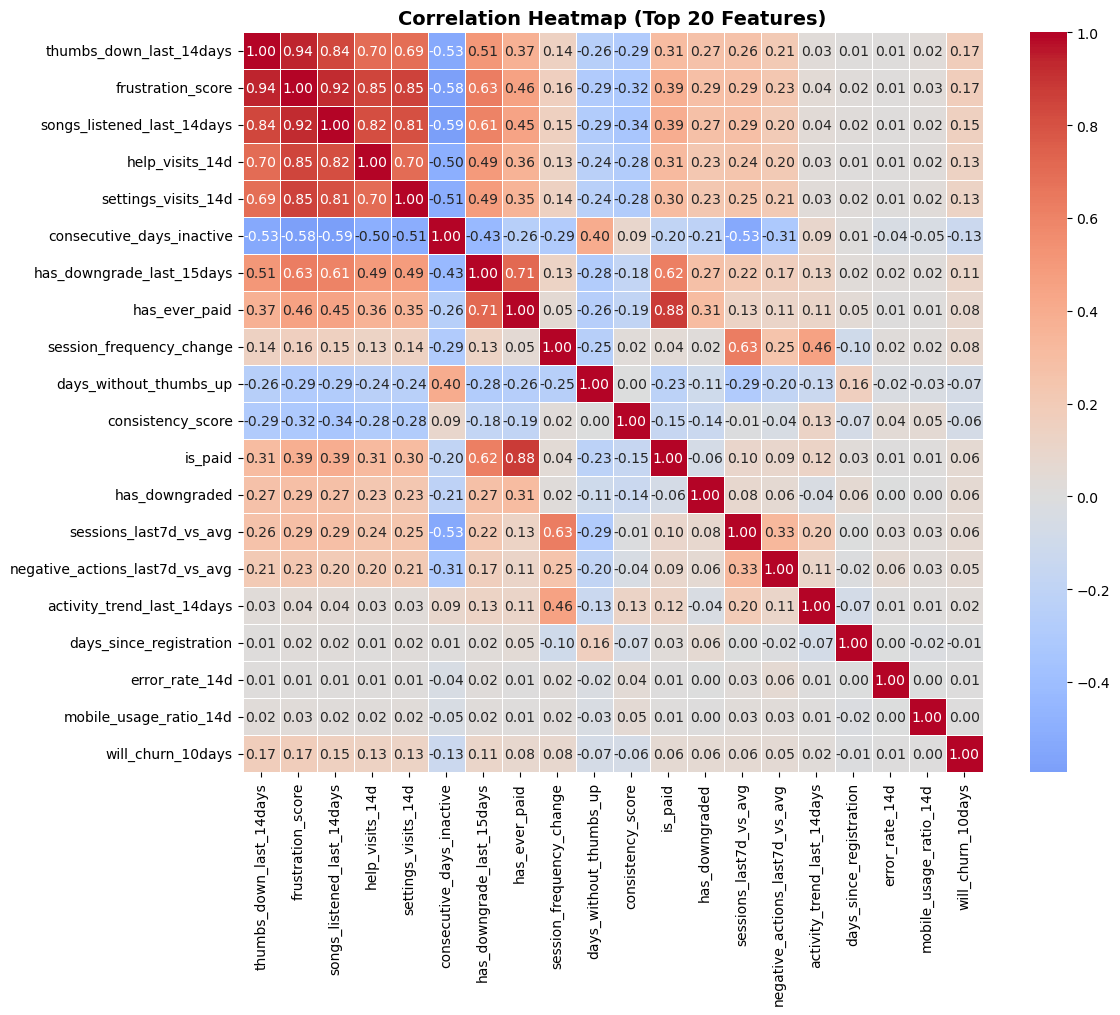

In [273]:
plot_correlation_heatmap(df_consistant)

## Model selection

### Second try with XG Boost

In [276]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
import numpy as np

def XGB_training(df_features):

    # Prepare data
    feature_cols = [col for col in df_features.columns 
                    if col not in ['userId', 'prediction_date','session_start', 'time','registration', 'will_churn_10days']]

    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']

    # Split (NO resampling here!)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Calculate scale_pos_weight: ratio of negative to positive class
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    print(f"Class distribution in train:")
    print(y_train.value_counts())
    print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

    # XGBoost with optimal parameters for churn prediction
    model = xgb.XGBClassifier(
        # Handle imbalanced classes
        scale_pos_weight=scale_pos_weight,  # CRITICAL for imbalanced data
        
        # Model complexity
        n_estimators=200,                   # Number of boosting rounds
        max_depth=6,                        # Tree depth (prevent overfitting)
        learning_rate=0.01,                 # Lower = more robust but slower
        
        # Optimization
        objective='binary:logistic',        # Binary classification,                 
        random_state=42,
        n_jobs=-1
    )

    # Train (simplified - no need to pass eval_metric again)
    print("\nTraining XGBoost model...")
    model.fit(
        X_train, y_train,
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

    # Feature importance
    import pandas as pd
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 30 Most Important Features:")
    print(feature_importance.head(30).to_string(index=False))
    return X_test, y_test, model


In [277]:
X_test, y_test, model_XGB = XGB_training(df_consistant)

Class distribution in train:
will_churn_10days
0    92415
1     5422
Name: count, dtype: int64

Calculated scale_pos_weight: 17.04

Training XGBoost model...
balanced accuracy: 0.6588938194077893
ROC-AUC: 0.7147

Confusion Matrix:
[[16755  6350]
 [  552   803]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.97      0.73      0.83     23105
       Churn       0.11      0.59      0.19      1355

    accuracy                           0.72     24460
   macro avg       0.54      0.66      0.51     24460
weighted avg       0.92      0.72      0.79     24460


Top 30 Most Important Features:
                       feature  importance
             frustration_score    0.370293
       thumbs_down_last_14days    0.101598
     consecutive_days_inactive    0.084420
     has_downgrade_last_15days    0.055815
             consistency_score    0.039792
        days_without_thumbs_up    0.039021
      session_frequency_change    0.036720
          

In [278]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

def find_optimal_threshold(model, X_test, y_test, thresholds=None, plot=True):
    """
    Trouve le seuil qui maximise la Balanced Accuracy
    
    Returns:
    --------
    best_threshold : float
        Optimal threshold
    best_score : float
        Balanced Accuracy at optimal threshold
    results : dict
        All thresholds and their scores
    """
    # Prédictions probabilistes
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Thresholds à tester
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.01)
    
    # Stocker les résultats
    scores = []
    
    # Tester chaque seuil
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        ba = balanced_accuracy_score(y_test, y_pred_binary)
        scores.append(ba)
    
    # Trouver le meilleur
    best_idx = np.argmax(scores)
    best_threshold = thresholds[best_idx]
    best_score = scores[best_idx]
    
    # Affichage
    print(f"🎯 Optimal Threshold: {best_threshold:.3f}")
    print(f"📊 Balanced Accuracy: {best_score:.3f}")
    
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, scores, linewidth=2)
        plt.axvline(best_threshold, color='red', linestyle='--', 
                    label=f'Optimal = {best_threshold:.3f}')
        plt.axhline(best_score, color='red', linestyle='--', alpha=0.3)
        plt.xlabel('Threshold', fontsize=12)
        plt.ylabel('Balanced Accuracy', fontsize=12)
        plt.title('Balanced Accuracy vs Classification Threshold', fontsize=14)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
    
    # Retourner les résultats
    results = {
        'thresholds': thresholds,
        'scores': scores
    }
    
    return best_threshold, best_score, results

🎯 Optimal Threshold: 0.490
📊 Balanced Accuracy: 0.661


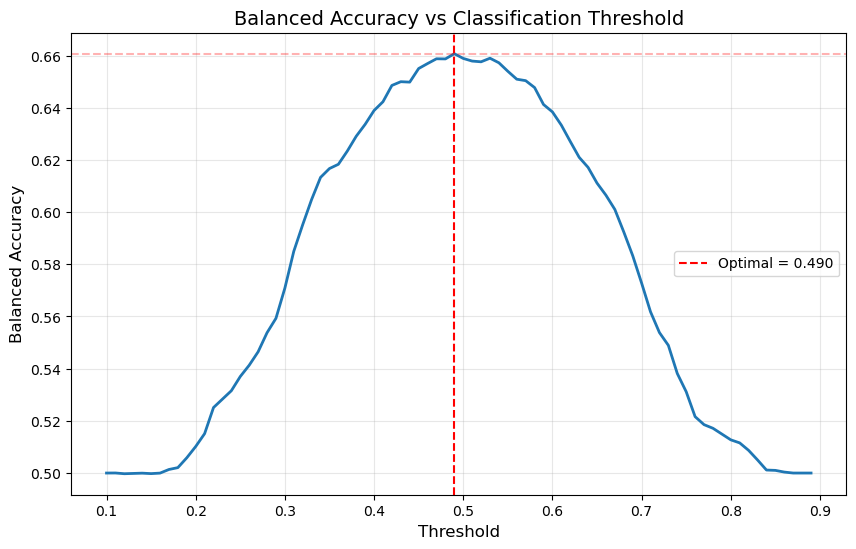

In [279]:
best_threshold, best_score, results = find_optimal_threshold(model_XGB, X_test, y_test, thresholds=None, plot=True)

### Rebalance the classes with a SMOTE function

In [191]:
# We apply smote only to train sets
def apply_smote(df_features):
    """
    Apply SMOTE to balance classes.
    """
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    
    # Prepare data
    feature_cols = [col for col in df_features.columns 
                   if col not in ['userId', 'session_start','prediction_date', 'registration', 'will_churn_10days']]
    
    X = df_features[feature_cols].fillna(0)
    y = df_features['will_churn_10days']
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"Before SMOTE: {len(y_train)} samples")
    print(f"After SMOTE:  {len(y_train_balanced)} samples")
    print(f"Class 0: {(y_train_balanced==0).sum()}, Class 1: {(y_train_balanced==1).sum()}")
    
    return X_train_balanced, y_train_balanced, X_test, y_test

In [192]:
X_train_balanced, y_train_balanced, X_test, y_test = apply_smote(df_consistant)

ValueError: could not convert string to float: '2018-10-19 02:52:28'

In [193]:
from sklearn.metrics import balanced_accuracy_score
def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, roc_auc_score
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    # Evaluate
    roc_auc = roc_auc_score(y_test, y_proba)
    
    print(f"balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    return rf, roc_auc

In [194]:
model_rf_SMOTE, score = train_random_forest(X_train_balanced, y_train_balanced, X_test, y_test)

balanced accuracy: 0.5844563215473931
ROC-AUC: 0.6576

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.95      0.83      0.89     23105
       Churn       0.11      0.34      0.16      1390

    accuracy                           0.80     24495
   macro avg       0.53      0.58      0.53     24495
weighted avg       0.91      0.80      0.85     24495



🎯 Optimal Threshold: 0.310
📊 Balanced Accuracy: 0.613


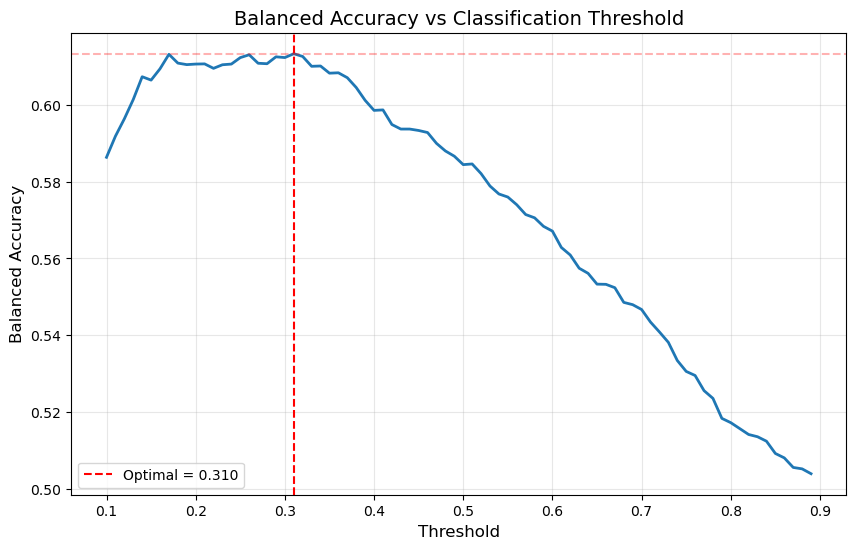

In [67]:
# Après avoir entraîné ton modèle
best_threshold, best_ba, results = find_optimal_threshold(model_rf_SMOTE, X_test, y_test)

# Prédictions avec le seuil optimal
y_pred_optimal = (model_rf_SMOTE.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

In [68]:
# Prepare data 
feature_cols = [col for col in df_consistant.columns 
                if col not in ['userId', 'session_start', 'registration', 'will_churn_10days']]

X = df_consistant[feature_cols].fillna(0)
y = df_consistant['will_churn_10days']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [69]:
model, score = train_random_forest(X_train, y_train, X_test, y_test)

ValueError: could not convert string to float: '2018-11-15'